# Summarize SEC Filings with OpenAI GPT3
Given the complex structure of 10-K SEC filings, we make our life easier by utilizing the [Extractor API](https://sec-api.io/docs/sec-filings-item-extraction-api) from [sec-api.io](https://sec-api.io/) to help us extract sections from SEC filings. This way we don’t have to develop a section extractor from scratch and instead just request the item of interest with a simple API call.



# Getting Started

Let’s start with installing the `openai` Python package.


In [ ]:
!pip install openai -q

In [ ]:
import openai

A free API key is available on OpenAI’s website (https://beta.openai.com/account/api-key)

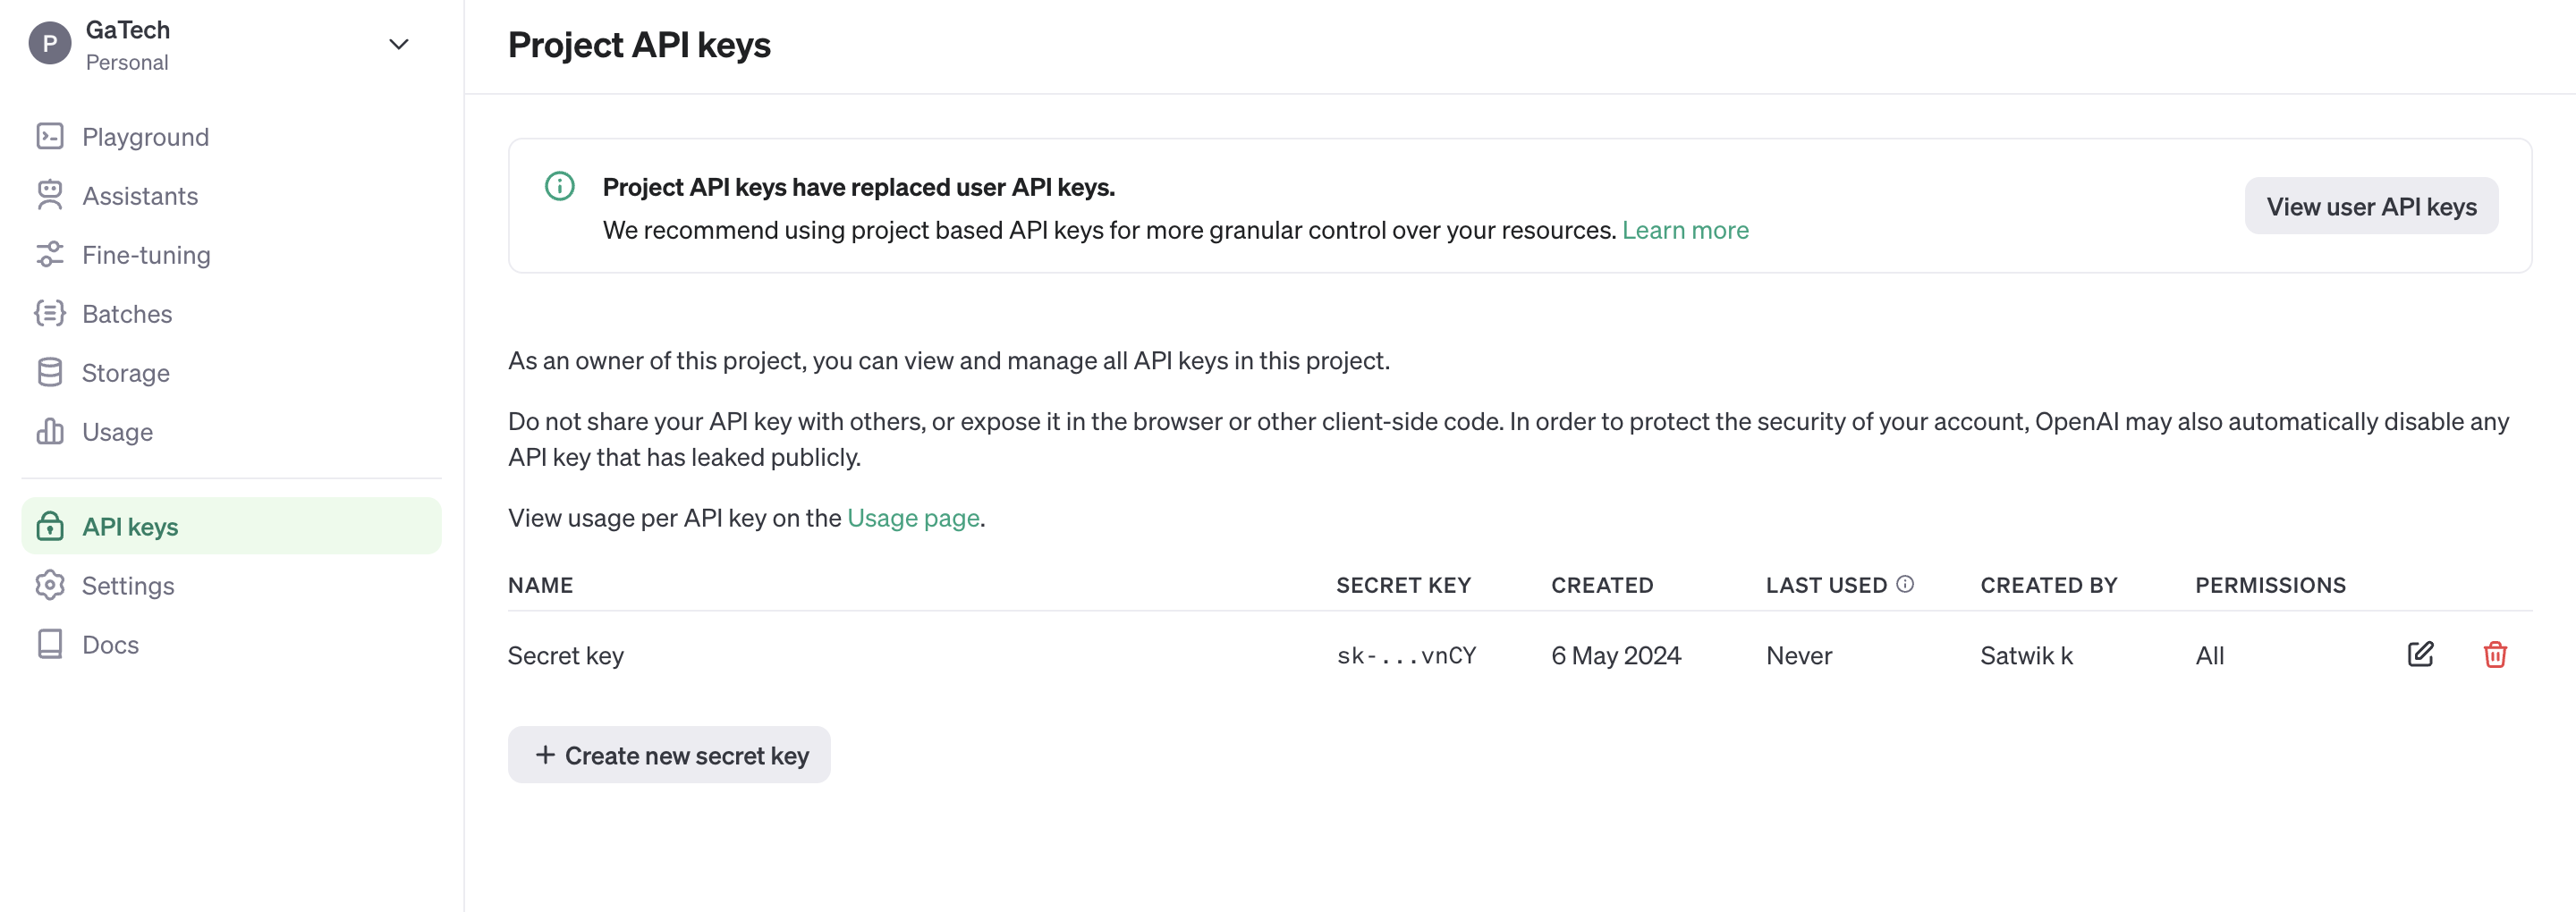

Next, import and set your API key.

In [ ]:
from getpass import getpass
openai.api_key = getpass()

··········


GPT3 (just “GPT” in the following) is a prompt-based AI that requires us to tell it (in words) what we want it to do by sending it our request, e.g. a question it should answer or a task it should perform, such as “summarize the following: …”.

For example, we can ask GPT who the greatest investor of all time is in just three lines of code. ( Which makes life easier , doesn't it? )

In [ ]:
prompt = "Who is the greatest investor of all time?"

engine = "text-davinci-003"

response = openai.Completion.create(
  engine=engine,
  prompt=prompt
)

response

<OpenAIObject text_completion id=cmpl-6SLSlPubay0yWtqYE4Qq6igKSSuhJ at 0x7fcf8764ca90> JSON: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "text": "\nThe greatest investor of all time is widely considered to be Warren Buffett."
    }
  ],
  "created": 1672213707,
  "id": "cmpl-6SLSlPubay0yWtqYE4Qq6igKSSuhJ",
  "model": "text-davinci-003",
  "object": "text_completion",
  "usage": {
    "completion_tokens": 15,
    "prompt_tokens": 66,
    "total_tokens": 81
  }
}

At first sight, GPT’s response seems a bit cryptic, but stay with me. The actual text response to our question sits in the `text` key inside the `choices` list.

# Language Models

Our example above used the `text-davinci-003` engine, or in other words, the Davinci language model. Think of a language model as the level of IQ and understanding of the world that GPT has. The larger the model, the better GPT understands what we want it to do and the better its responses will be. A model is like the skill programs that Neo and Morpheus uploaded into their brains in The Matrix.

OpenAI offers four different models: Ada, Babbage, Curie, Davinci. Davinci represents the largest model, i.e. GPT shows the highest IQ and understanding of our world when using this model. On the other spectrum lives the Ada model, pretty fast, but also not the sharpest tool in the house.

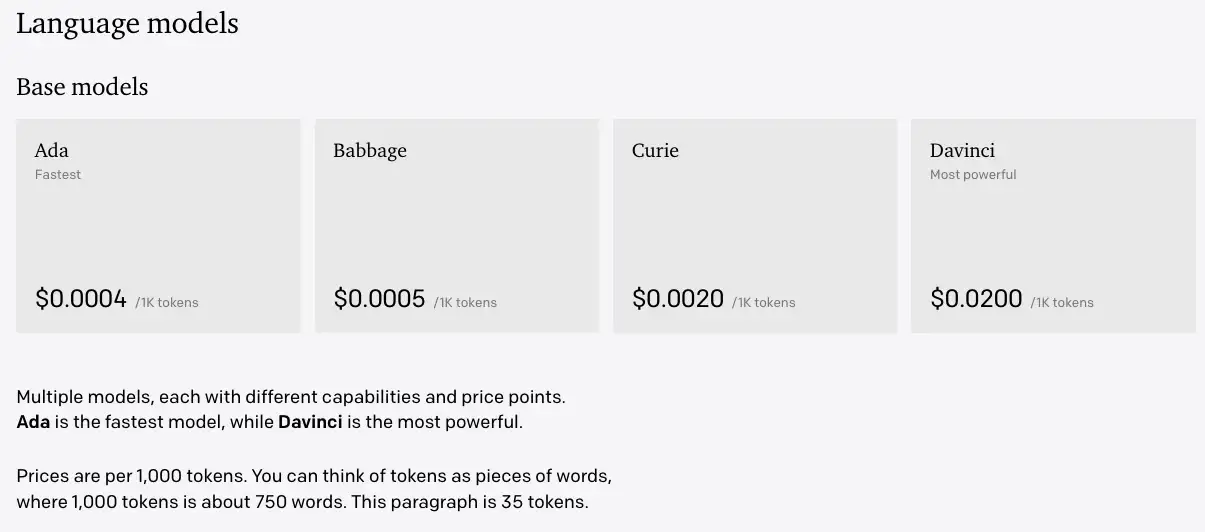

# Extracting Sections from SEC Filings

In order to extract text section from SEC 10-K filings, we use the [Extractor API](https://sec-api.io/docs/sec-filings-item-extraction-api) offered by [sec-api.io](https://sec-api.io/). The Extractor API accepts three parameters and returns the extracted filing section as HTML or cleaned text:

- URL of 10-K filing
- Section name to be extracted, e.g. Item 1A Risk Factors
- Return type: HTML or raw text without HTML/XBRL/CSS

A free API key can be availed through here: https://sec-api.io/signup/free

We start with installing the `sec-api` Python package.

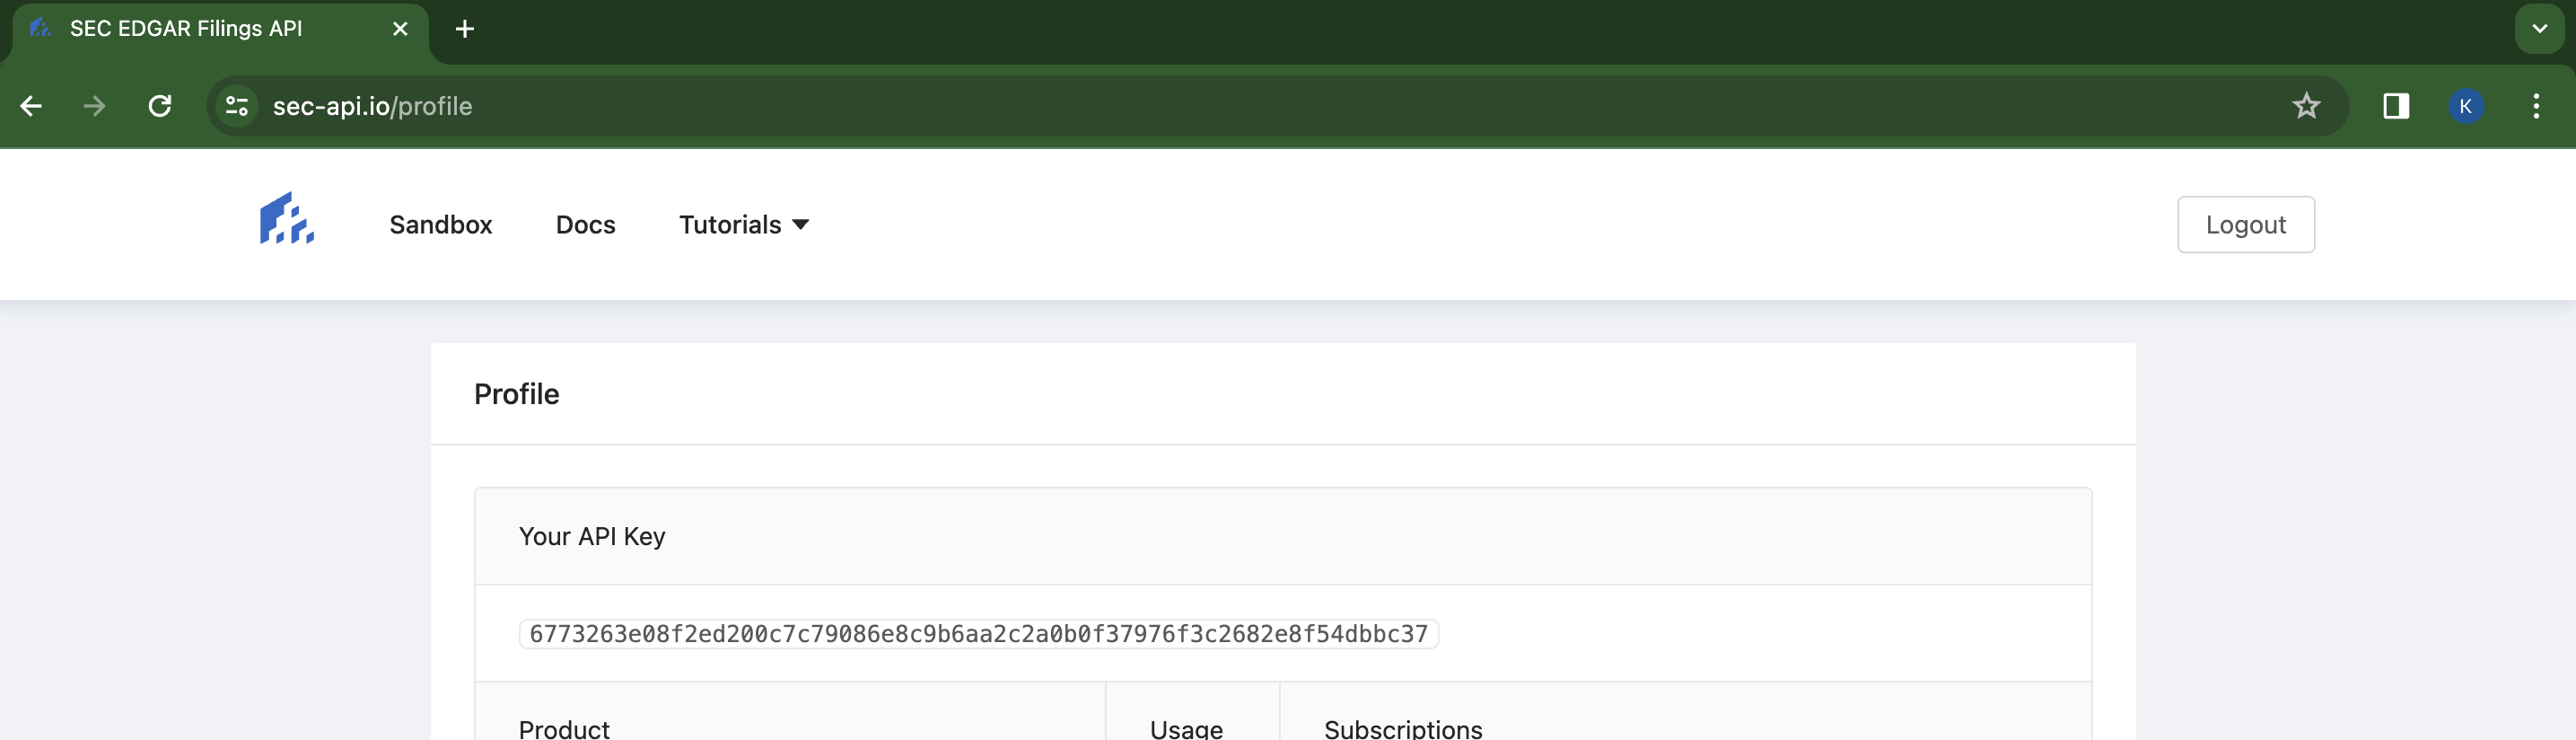

In [ ]:
!pip install sec-api

Extracting the Risk Factor section in Item 1A of a 10-K SEC Filing is as simple as running the following four lines of code. The `extractorApi.get_section()` method returns a string with the extracted section as cleaned and standardized text.

In [ ]:
from sec_api import ExtractorApi

extractorApi = ExtractorApi("YOUR_API_KEY")

In [ ]:
filing_url = "https://www.sec.gov/Archives/edgar/data/1318605/000156459021004599/tsla-10k_20201231.htm"

section_text = extractorApi.get_section(filing_url, "1A", "text")

section_text

' ITEM 1A. RISK FACTORS\n\nYou should carefully consider the risks described below together with the other information set forth in this report, which could materially affect our business, financial condition and future results. The risks described below are not the only risks facing our company. Risks and uncertainties not currently known to us or that we currently deem to be immaterial also may materially adversely affect our business, financial condition and operating results. \n\nRisks Related to Our Ability to Grow Our Business\n\nWe may be impacted by macroeconomic conditions resulting from the global COVID-19 pandemic.\n\nSince the first quarter of 2020, there has been a worldwide impact from the COVID-19 pandemic. Government regulations and shifting social behaviors have limited or closed non-essential transportation, government functions, business activities and person-to-person interactions. In some cases, the relaxation of such trends has recently been followed by actual or 

In [ ]:
import re

section_text = re.sub("##TABLE_START|##TABLE_END", "", section_text)

# GPT Summarizer — Putting It All Together

Putting it all together is a breeze. We simply tell GPT to summarize the extracted text section in 15 sentences and add the section to our prompt after our task definition.

In [ ]:
prompt = f"Summarize the following text in 15 sentencens:\n{section_text}"

In [ ]:
response = openai.Completion.create(
    engine="text-davinci-003",
    prompt=prompt,
    temperature=0.3,
    max_tokens=500,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=1
)

InvalidRequestError: ignored

Depending on the length of the extracted section, the `create()` method might throw an error informing us about exceeding the maximum input token length. In other words, GPT is only able to handle a fixed maximum number of input (and output) tokens.

To ensure that we don’t exceed the maximum input length, we split the extracted section into multiple text chunks, summarize each chunk independently and finally merge all summarized chunks using a simple `.join()` function.

Depending on the model used, requests can use up to 4097 tokens shared between prompt and completion. If your prompt is 4000 tokens, your completion can be 97 tokens at most ([see details here](https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them)).

Given the token-to-word ratio below, we can send approximately 2900 words to GPT assuming a 5 sentence summary per section chunk.

- Max tokens per request: 4000 tokens (leaving 97 tokens as a safety buffer) = 3000 words
- Max prompt tokens: “Summarize the following text in five sentences” has 7 words = 10 tokens
- Max tokens of returned summary (5 sentences): 20 words per sentence. 5 * 20 = 100 words = 133 tokens
- Max tokens of section chunk: 4000-10-133 = 3857 tokens = 2900 words

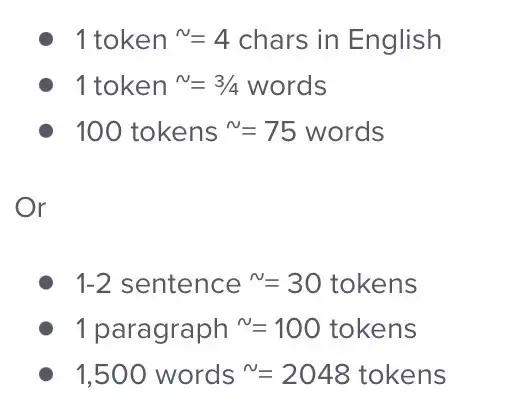

We can choose from a plethora of strategies to split up the section into smaller chunks. The simplest approach is creating a single list of all words by splitting the entire section on whitespaces, and then creating buckets of words with words evenly distributed across all buckets. The downside is that we are likely to split a sentence half-way through and lose the meaning of the sentence because GPT ends up summarizing the first half of the sentence independently from the second half — ignoring any relations between the two chunks. Other options include tokenizers such as SentencePiece and spaCy’s sentence splitter.

Choosing the later generates the most stable results. The example splits the text “My first birthday was great. My 2. was even better.” into a list of two sentences.

In [ ]:
!python -m spacy download en_core_web_sm

In [ ]:
import spacy
from spacy.lang.en import English

nlp = spacy.load('en_core_web_sm')

text = 'My first birthday was great. My 2. was even better.'

for i in nlp(text).sents:
  print(i)

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


My first birthday was great.
My 2. was even better.


spaCy correctly detected the second sentence instead of splitting it after the “2.”. Now, let’s write a `text_to_chunks` helper function to generate lists of sentences where each list holds at most 2700 words. 2900 words was the initially calculated word limit, but we want to ensure to have enough buffer for words that are longer than 1.33 tokens.

In [ ]:
def text_to_chunks(text):
  chunks = [[]]
  chunk_total_words = 0

  sentences = nlp(text)

  for sentence in sentences.sents:
    # print(dir(sentence))
    chunk_total_words += len(sentence.text.split(" "))

    if chunk_total_words > 2700:
      chunks.append([])
      chunk_total_words = len(sentence.text.split(" "))

    chunks[len(chunks)-1].append(sentence.text)

  return chunks

chunks = text_to_chunks(section_text)

print(chunks)

[[' ITEM 1A.', 'RISK FACTORS\n\nYou should carefully consider the risks described below together with the other information set forth in this report, which could materially affect our business, financial condition and future results.', 'The risks described below are not the only risks facing our company.', 'Risks and uncertainties not currently known to us or that we currently deem to be immaterial also may materially adversely affect our business, financial condition and operating results.', '\n\n', 'Risks Related to Our Ability to Grow Our Business\n\nWe may be impacted by macroeconomic conditions resulting from the global COVID-19 pandemic.\n\n', 'Since the first quarter of 2020, there has been a worldwide impact from the COVID-19 pandemic.', 'Government regulations and shifting social behaviors have limited or closed non-essential transportation, government functions, business activities and person-to-person interactions.', 'In some cases, the relaxation of such trends has recently

Next, we wrap the text summarization logic into a `summarize_text` function.



In [ ]:
def summarize_text(text):
  # prompt = f"Summarize the following text so that your output can be read without having to read the entire text. Use the third person:\n\n{text}"
  prompt = f"Summarize the following text in five sentences:\n\n{text}"

  response = openai.Completion.create(
      engine="text-davinci-003",
      prompt=prompt,
      temperature=0.9, # 0.3
      max_tokens=250, # = 112 words
      top_p=1,
      frequency_penalty=0,
      presence_penalty=1
  )

  return response["choices"][0]["text"]

Next to the initial `.create()` parameters, we added some new options:

- `temperature`: Higher values means the model will take more risks. Try 0.9 for more creative applications, and 0 for ones with a well-defined answer.
- `max_tokens`: The maximum number of tokens to generate in the completion.
- `top_p`: An alternative to sampling with temperature, where the model considers the results of the tokens with top_p probability mass. So 0.1 means only the tokens comprising the top 10% probability mass are considered.
- `frequency_penalty`: Number between -2.0 and 2.0. Positive values penalize new tokens based on their existing frequency in the text so far, decreasing the model’s likelihood to repeat the same line verbatim.
- `presence_penalty`: Number between -2.0 and 2.0. Positive values penalize new tokens based on whether they appear in the text so far, increasing the model’s likelihood to talk about new topics.

In [ ]:
summary = summarize_text(" ".join(chunks[0]))
summary

" We may not be successful in our efforts to do so or efficiently coordinate the global activities related to these new factories and products, which could harm our business, prospects, operating results and financial condition. \n\nThe risks associated with being able to grow Tesla's business include macroeconomic conditions resulting from the global COVID-19 pandemic, delays in launching and ramping production of products and features, difficulties accurately forecasting demand, competition, volatility in oil and gasoline prices, government regulations and economic incentives, and perceptions about electric vehicle features. The ability to increase production, make vehicles affordable globally and streamline delivery logistics is dependent on the construction and ramp of specialized factories. Any delays, complications or inaccuracies in managing these operations can have significant impacts on their brand, business, prospects, financial condition and operating results."

Our final piece of code looks like this:

In [ ]:
chunk_summaries = []

for chunk in chunks:
  chunk_summary = summarize_text(" ".join(chunk))
  chunk_summaries.append(chunk_summary)

In [ ]:
section_summary = " ".join(chunk_summaries)

The example of a complete `section_summary` text looks already very promising:

In [ ]:
section_summary

" If we are unable to do so, or if we experience delays in the construction of or ramp at our new factories, or if we are unable to generate and sustain demand for vehicles manufactured there, our business, prospects, financial condition and operating results may be harmed. \n\nRisk factors related to the global COVID-19 pandemic, such as macroeconomic conditions, government regulations, shifting social behaviors, supplier suspensions, employee furloughs, and increased demand for personal electronics, could have a negative impact on Tesla's business, financial condition and future results. Additionally, delays in launching and ramping the production of their products, managing growth, increasing sales capabilities, delivering vehicles, and servicing and charging networks could also harm their brand,  We have certain obligations under these agreements, including to make payments for rent and research and development activities. If we fail to comply with our obligations under the agreeme

As we can see, there is still room for improvement. For example, GPT switches between first and third person narration (“we” vs “Tesla”) and sometimes relationships between entities are not clear (“under the agreement” — what agreement?). We can significantly improve GPT’s output by improving our prompt, i.e. task definition.

For example, we can explicitly tell GPT to use third person narration. Also, specifying the exact number of sentences to be generated for a summary of a section chunk is not the best way to achieve a reliable output as some sections might contain more relevant facts than others. Keep in mind, the `text_to_chunks` function doesn’t consider context while splitting sentences. In other words, the first sentence of a chunk might contextually refer to the content of the previous chunk, but the way we implemented the summarizer, GPT ends up ignoring the contextual reference.

Other options for the `prompt` are:

To extract significant information from SEC EDGAR 10-K filings, you can ask prompts that target specific sections and data points within the filings. Here are some example prompts and how they can be useful:

1. **Financial Performance:**
   - Prompt: "Retrieve key financial metrics such as revenue, net income, and earnings per share from the Income Statement."
   - Usefulness: This helps analyze the financial health and performance of the company over a specific reporting period.

2. **Business Overview:**
   - Prompt: "Extract information about the company's business segments, geographical regions, and major products/services."
   - Usefulness: Understanding the company's business structure and operations provides insights into its diversification and market focus.

3. **Risk Factors:**
   - Prompt: "Identify and summarize significant risk factors disclosed in the Risk Factors section."
   - Usefulness: Assessing risk factors helps in understanding potential challenges and vulnerabilities that could impact the company's future performance.

4. **Management Discussion & Analysis (MD&A):**
   - Prompt: "Extract management's narrative on financial results, market conditions, and strategic initiatives from the MD&A section."
   - Usefulness: This provides qualitative insights into the company's performance drivers, industry trends, and future outlook.

5. **Corporate Governance:**
   - Prompt: "Retrieve information about board composition, executive compensation, and governance practices."
   - Usefulness: Understanding governance structures and practices helps evaluate transparency and alignment with shareholder interests.

6. **Legal Proceedings:**
   - Prompt: "Summarize ongoing or significant legal proceedings disclosed in the Legal Proceedings section."
   - Usefulness: Identifying legal risks and liabilities informs assessments of potential impact on the company's financial and operational stability.

Prompt-based extraction allows for targeted retrieval of specific information, streamlining the analysis of complex 10-K filings. This approach helps analysts and investors efficiently gather insights crucial for informed decision-making and comprehensive understanding of a company's performance and risk profile.